(224, 224, 3)


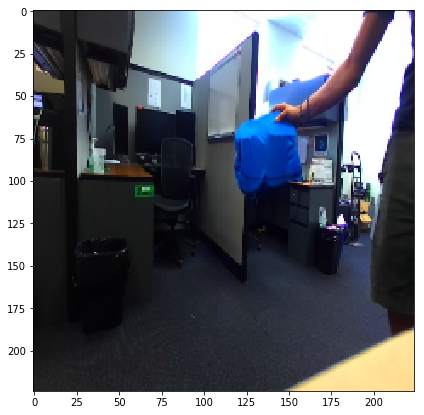

In [67]:
%matplotlib inline
from __future__ import print_function
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD
import h5py
import numpy as np
import os

DATA = lambda p: os.path.join('../datafiles/zed-subset', p)

def myimread(fname):
    import skimage.io, skimage.transform
    im = skimage.transform.resize(skimage.io.imread(fname), (224, 224))
    return im[...,::-1]*255

def myimshow(im):
    plt.figure(figsize=(7,7))
    plt.imshow(im[...,::-1]/255)
    
def myimshow_grey(im):
    plt.figure(figsize=(7,7))
    plt.imshow(im, cmap=plt.get_cmap('gray'), vmin=0, vmax=255)

test_im = myimread(DATA('556-left.jpeg'))
print(test_im.shape)

myimshow(test_im)

In [54]:
def ConvMap(vgg_weights_path):
    REMOVE_EXCESSIVE_POOLING = True
    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=(3,224,224), name='z11'))
    model.add(Convolution2D(64, 3, 3, activation='relu', name='conv11'))
    model.add(ZeroPadding2D((1,1), name='z12'))
    model.add(Convolution2D(64, 3, 3, activation='relu', name='conv12'))
    model.add(MaxPooling2D((2,2), strides=(2,2), name='max1'))

    model.add(ZeroPadding2D((1,1), name='z21'))
    model.add(Convolution2D(128, 3, 3, activation='relu', name='conv21'))
    model.add(ZeroPadding2D((1,1), name='z22'))
    model.add(Convolution2D(128, 3, 3, activation='relu', name='conv22'))
    model.add(MaxPooling2D((2,2), strides=(2,2), name='max2'))

    model.add(ZeroPadding2D((1,1), name='z31'))
    model.add(Convolution2D(256, 3, 3, activation='relu', name='conv31'))
    model.add(ZeroPadding2D((1,1), name='z32'))
    model.add(Convolution2D(256, 3, 3, activation='relu', name='conv32'))
    model.add(ZeroPadding2D((1,1), name='z33'))
    model.add(Convolution2D(256, 3, 3, activation='relu', name='conv33'))
    if not REMOVE_EXCESSIVE_POOLING:
        model.add(MaxPooling2D((2,2), strides=(2,2), name='max3'))

    model.add(ZeroPadding2D((1,1), name='z41'))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv41'))
    model.add(ZeroPadding2D((1,1), name='z42'))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv42'))
    model.add(ZeroPadding2D((1,1), name='z43'))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv43'))
    if not REMOVE_EXCESSIVE_POOLING:
        model.add(MaxPooling2D((2,2), strides=(2,2), name='max4'))

    model.add(ZeroPadding2D((1,1), name='z51'))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv51'))
    model.add(ZeroPadding2D((1,1), name='z52'))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv52'))
    model.add(ZeroPadding2D((1,1), name='z53'))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv53'))
    model.add(MaxPooling2D((2,2), strides=(2,2), name='max5'))

    # model.add(Flatten())
    # model.add(Dense(4096, activation='relu'))
    # model.add(Dropout(0.5))
    # model.add(Dense(4096, activation='relu'))
    # model.add(Dropout(0.5))
    # model.add(Dense(1000, activation='softmax'))
    
    layer_key = {
        'z11': 'layer_0', 'conv11': 'layer_1',
        'z12': 'layer_2', 'conv12': 'layer_3',
        'max1': 'layer_4',
        'z21': 'layer_5', 'conv21': 'layer_6',
        'z22': 'layer_7', 'conv22': 'layer_8',
        'max2': 'layer_9',
        'z31': 'layer_10', 'conv31': 'layer_11',
        'z32': 'layer_12', 'conv32': 'layer_13',
        'z33': 'layer_14', 'conv33': 'layer_15',
        'max3': 'layer_16',
        'z41': 'layer_17', 'conv41': 'layer_18',
        'z42': 'layer_19', 'conv42': 'layer_20',
        'z43': 'layer_21', 'conv43': 'layer_22',
        'max4': 'layer_23',
        'z51': 'layer_24', 'conv51': 'layer_25',
        'z52': 'layer_26', 'conv52': 'layer_27',
        'z53': 'layer_28', 'conv53': 'layer_29',
        'max5': 'layer_30',
    }
    
    if REMOVE_EXCESSIVE_POOLING:
        del layer_key['max3'], layer_key['max4']

    with h5py.File(vgg_weights_path) as f:
        for name, layer in layer_key.iteritems():
            g = f[layer]
            weights = [g['param_{}'.format(p)] for p in range(g.attrs['nb_params'])]
            model.get_layer(name).set_weights(weights)
    
    print('VGG loaded. (%d layers)'%len(model.layers))
    
    model.add(ZeroPadding2D((1,1), name='z61'))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv61'))
    model.add(ZeroPadding2D((1,1), name='z62'))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv62'))
    
    print('ConvMap completed. (%d layers)'%len(model.layers))
        
    for layer in model.layers:
        if 'conv' in layer.name or 'max' in layer.name:
            print(layer.name, layer.output_shape)

    return model

def predict(im):
    im[:,:] -= np.array([103.939, 116.779, 123.68])
    im = im.transpose((2,0,1))
    im = np.expand_dims(im, axis=0)
    model = ConvMap('vgg16_weights.h5')
    
    # sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
    # model.compile(optimizer=sgd, loss='categorical_crossentropy')
    out = model.predict(im)
    return out

conv_map = predict(test_im)
print('conv_map', conv_map.shape)

VGG loaded. (29 layers)
ConvMap completed. (33 layers)
conv11 (None, 64, 224, 224)
conv12 (None, 64, 224, 224)
max1 (None, 64, 112, 112)
conv21 (None, 128, 112, 112)
conv22 (None, 128, 112, 112)
max2 (None, 128, 56, 56)
conv31 (None, 256, 56, 56)
conv32 (None, 256, 56, 56)
conv33 (None, 256, 56, 56)
conv41 (None, 512, 56, 56)
conv42 (None, 512, 56, 56)
conv43 (None, 512, 56, 56)
conv51 (None, 512, 56, 56)
conv52 (None, 512, 56, 56)
conv53 (None, 512, 56, 56)
max5 (None, 512, 28, 28)
conv61 (None, 512, 28, 28)
conv62 (None, 512, 28, 28)
conv_map (1, 512, 28, 28)


16 convmaps out of 512.
shape: (28, 28)


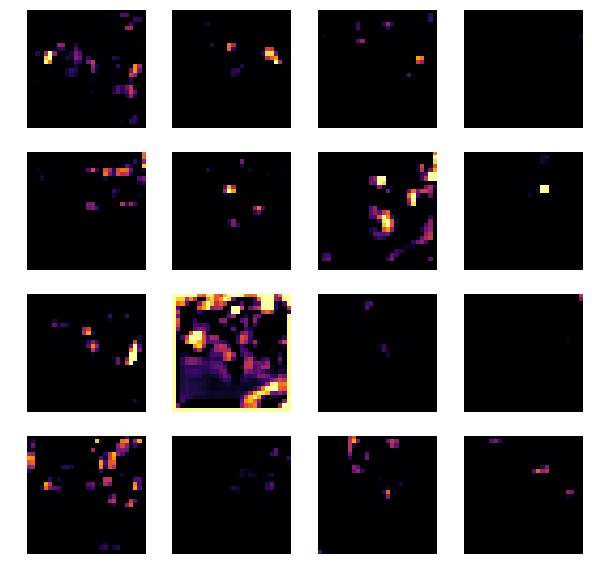

In [59]:
def show_conv_map(im):
    N_sumples = 16
    sample = np.random.choice(range(conv_map.shape[1]), N_sumples, False)
    print('%d convmaps out of %d.'%(N_sumples, conv_map.shape[1]))
    print('shape:', conv_map.shape[2:])
    plt.figure(figsize=(10,10))
    for i in xrange(N_sumples):
        plt.subplot(4,4,i+1)
        plt.axis('off')
        plt.imshow(conv_map[0][sample[i]], cmap=plt.get_cmap('inferno'), vmin=0, vmax=255)
    
show_conv_map(conv_map)

# Superpixel pooling

252


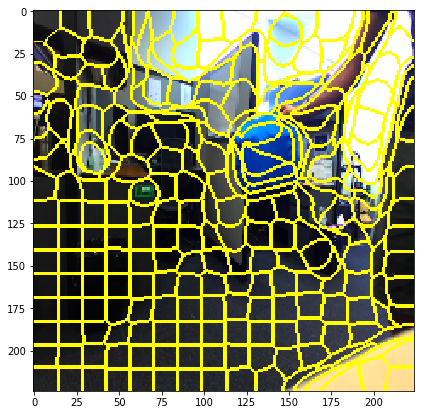

In [84]:
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries

def myslic(im):
    im_float = im[...,::-1]/255
    segments = slic(im/255, n_segments = 250, sigma = 5)
    plt.figure(figsize=(7,7))
    plt.imshow(mark_boundaries(im_float, segments))
    return segments

test_segments = myslic(test_im)

## For just one superpixel

In [164]:
seg_mask = np.array([
    [1, 1, 2, 2],
    [1, 1, 0, 2],
    [1, 0, 0, 2],
    [0, 0, 0, 2]
])

def f_superpixel_weights(image_shape, convmap_shape, image_type=bool):
    from numpy.lib.stride_tricks import as_strided as ast
    # print(image_shape,convmap_shape)
    kernel = np.ones((1,1)+convmap_shape)
    subsample = tuple(np.array(image_shape) / np.array(convmap_shape))
    # print('stride', subsample)
    strides = np.array(np.zeros(image_shape, dtype=image_type).strides)
    strides = tuple(np.array(strides)*2)+tuple(strides)
    shape = convmap_shape+subsample
    return lambda x:np.sum(ast(x, shape=shape, strides=strides), axis=(2,3))

superpixel_weights(seg_mask.shape, (2,2))(seg_mask==1)

array([[4, 0],
       [1, 0]])

In [165]:
def superpixel_weights():
    fW = f_superpixel_weights(test_segments.shape, conv_map[0][0].shape)
    N_segments = np.max(test_segments)+1
    W = np.zeros((N_segments,)+conv_map[0][0].shape)
    for t in xrange(np.max(test_segments)+1):
        W[t]=fW(test_segments==t)
    print(len(W), W[0].shape)
    
superpixel_weights()

253 (28, 28)


## Repeat and convert to block matrices for vectorization

In [178]:
_N = np.max(seg_mask)+1
_seg_mask = np.repeat(seg_mask[np.newaxis,...],_N,axis=0)
# print(_seg_mask.shape)
_R = np.arange(_N)[...,np.newaxis,np.newaxis]
_W0 = _seg_mask==_R
print(_W0[0].strides)
print(_W0.strides, _W0.shape)
print(_W0)

from numpy.lib.stride_tricks import as_strided as ast
__W = ast(_W0, shape=(3,2,2,2,2), strides=(16,8,2,4,1))
print(__W[0])
# print(__W.shape)                     

(4, 1)
(16, 4, 1) (3, 4, 4)
[[[False False False False]
  [False False  True False]
  [False  True  True False]
  [ True  True  True False]]

 [[ True  True False False]
  [ True  True False False]
  [ True False False False]
  [False False False False]]

 [[False False  True  True]
  [False False False  True]
  [False False False  True]
  [False False False  True]]]
[[[[False False]
   [False False]]

  [[False False]
   [ True False]]]


 [[[False  True]
   [ True  True]]

  [[ True False]
   [ True False]]]]


## Now vectorize for all superpixels

In [355]:
def f_superpixel_weights2(image_shape, convmap_shape, N_seg, image_type=bool):
    from numpy.lib.stride_tricks import as_strided as ast
    # print(image_shape,convmap_shape)
    kernel = np.ones((1,1)+convmap_shape)
    subsample = tuple(np.array(image_shape) / np.array(convmap_shape))
    # print('stride', subsample)
    _strides = np.array(np.zeros((2,)+image_shape, dtype=image_type).strides)
    strides = (_strides[0],)+tuple(np.array(_strides[1:])*2)+tuple(_strides[1:])
    shape = (N_seg,)+convmap_shape+subsample
#     print('ss',shape,strides)
#     def __sum(x):
#         _W = ast(x, shape=shape, strides=strides)
#         print(_W[1])
#         return np.sum(_W, axis=(3,4))
#     return __sum
    return lambda x:np.sum(ast(x, shape=shape, strides=strides), axis=(3,4))

def superpixel_weights2(segments, conv_map):    
    print('segments.shape:', segments.shape)
    print('conv_map.shape:', conv_map.shape)
    
    N_segments = np.max(segments)+1
    print('Number of superpixels:', N_segments)
    
    subsample = tuple(np.array(segments.shape) / np.array(conv_map[0][0].shape))
    print('conv_map downsample ratio:', subsample)
    
    from skimage.util import view_as_blocks
    W = np.repeat(segments[np.newaxis,...],N_segments,axis=0)
    W = W==np.arange(N_segments)[...,np.newaxis,np.newaxis]
    print('W.shape:', W.shape)
    
    W_blocks = view_as_blocks(W, (1,)+subsample)
    print('blocked:',W_blocks.shape,W_blocks.dtype)
    W = np.sum(W_blocks, axis=(3,4,5))
    print('W.shape:', W.shape)
    print('sum(W):',np.sum(W), np.product(conv_map[0][0].shape+subsample))
    
#     fW = f_superpixel_weights2(segments.shape, conv_map[0][0].shape, N_segments)
#     W = np.repeat(segments[np.newaxis,...],N_segments,axis=0)
#     W = W==np.arange(N_segments)[...,np.newaxis,np.newaxis]
#     W = fW(W)
    
    W_norm = np.sum(W,axis=(1,2))
    W_norm[W_norm==0] = 1.
    return W.astype(float)/W_norm[...,np.newaxis,np.newaxis]

# test_segments_weights = superpixel_weights2(seg_mask, np.ones((1,1,2,2)))
test_segments_weights = superpixel_weights2(test_segments, conv_map)



segments.shape: (224, 224)
conv_map.shape: (1, 512, 28, 28)
Number of superpixels: 253
conv_map downsample ratio: (8, 8)
W.shape: (253, 224, 224)
blocked: (253, 28, 28, 1, 8, 8) bool
W.shape: (253, 28, 28)
sum(W): 50176 50176


## Feature map (Unary potential)

(253, 28, 28) (1, 512, 28, 28)
(253, 512)


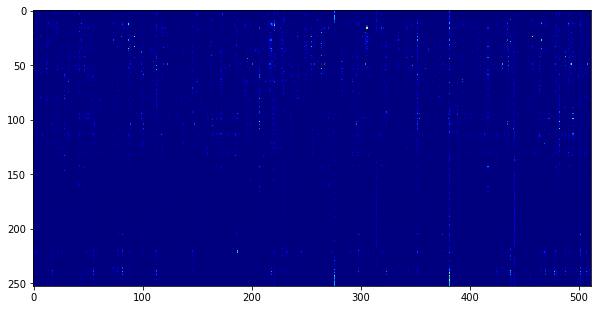

In [358]:
print(test_segments_weights.shape, conv_map.shape)
H = np.einsum('tij,kij->tk', test_segments_weights, conv_map[0])
print(H.shape)
plt.figure(figsize=(10,7))
plt.imshow(H, cmap='jet')

## pyimagesearch on superpixels
[Accessing Individual Superpixel](http://www.pyimagesearch.com/2014/12/29/accessing-individual-superpixel-segmentations-python/)

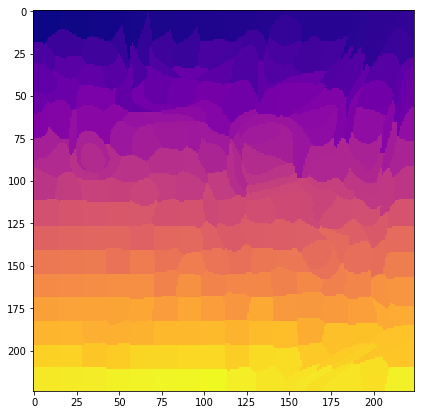

In [345]:
plt.figure(figsize=(7,7))
plt.imshow(test_segments, cmap='plasma')

# check area
for segi in np.unique(segments):
    if np.sum(segments == segi)==0:
        print(segi)